In [1]:
import numpy as np
from scipy import misc
from PIL import Image
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn  
import pandas as pd  
import pickle  
from keras import layers  
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout  
from keras.models import Sequential, Model, load_model  
from keras.preprocessing import image  
from keras.preprocessing.image import load_img  
from keras.preprocessing.image import img_to_array  
from keras.applications.imagenet_utils import decode_predictions  
from keras.utils import layer_utils, np_utils  
from keras.utils.data_utils import get_file  
from keras.applications.imagenet_utils import preprocess_input  
from keras.utils.vis_utils import model_to_dot  
from keras.utils import plot_model  
from keras.initializers import glorot_uniform  
from keras import losses  
import keras.backend as K  
from keras.callbacks import ModelCheckpoint  
from sklearn.metrics import confusion_matrix, classification_report  
import tensorflow as tf
import os
import os.path

Using TensorFlow backend.


In [2]:
# Ruta de la imagen y extensiones válidas.
imageDir = 'D:/Competicion/WIDS/train_images/' #Especific tu ruta aqui
image_path_list = []
valid_image_extensions = [".jpg", ".jpeg", ".png", ".tif", ".tiff"] # Especifique sus extensiones vald aquí
valid_image_extensions = [item.lower() for item in valid_image_extensions]

# Crear una lista de todos los archivos en el directorio y
# Adjuntar archivos con una extensión válida a la lista image_path
for file in os.listdir(imageDir):
    extension = os.path.splitext(file)[1]
    if extension.lower() not in valid_image_extensions:
        continue
    image_path_list.append(os.path.join(imageDir, file))

# close any open windows
cv2.destroyAllWindows()

In [3]:
images = []
for value in image_path_list:
    images.append(value.split('/')[4])

In [4]:
orden_image = pd.DataFrame({'image_id':images,'orden':range(15244)})

In [5]:
np.shape(image_path_list)

(15244,)

In [6]:
x_train_original = np.empty((15244, 256, 256, 3), dtype=np.uint8)
for i, fpath in enumerate(image_path_list):
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    x_train_original[i, ...] = img.transpose(0, 1, 2)

In [7]:
x_train_original.shape

(15244, 256, 256, 3)

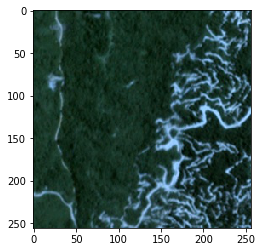

In [8]:
imgplot = plt.imshow(x_train_original[1])
plt.show()

**Cargando Labels en DataFrame**

In [9]:
y_train_original = pd.read_csv('D:/Competicion/WIDS/traininglabels.csv',sep = ',')

In [10]:
y_train_original = y_train_original.merge(orden_image)

In [11]:
y_train_original.sort_values(by = 'orden', ascending = True, inplace = True)

In [12]:
y_tot = pd.DataFrame({'has_oilpalm':y_train_original['has_oilpalm'].values,'orden':y_train_original['orden']})

In [13]:
len(y_tot['has_oilpalm'])

15244

In [14]:
sum(y_tot['has_oilpalm'])

942

**Sacando Train,Test - Metodo 1**

In [15]:
import random 
c = range(15244)
sample = random.sample(c,12195)
sample_train = []
sample_test = []
for m in c:
    if m in sample:
        sample_train.append(m)
    else:
        sample_test.append(m)

In [16]:
sample_test_data = pd.DataFrame({'orden':sample_test,'tipo_base':'data_Test'})
sample_train_data = pd.DataFrame({'orden':sample_train,'tipo_base':'data_Train_total'})

In [17]:
y_validation = y_tot.merge(sample_test_data)
len(y_validation)

3049

In [18]:
y = y_tot.merge(sample_train_data,how = 'right')
len(y)

12195

In [19]:
del m
c_val = range(12195)
sample_val = random.sample(c_val,3049)
sample_train_validation = []
sample_train_final = []
for m in c_val:
    if m in sample_val:
        sample_train_validation.append(m)
    else:
        sample_train_final.append(m)

In [20]:
sample_trainValidation_data = pd.DataFrame({'orden2':sample_train_validation,'tipo_base2':'data_Validation'})
sample_trainFinal_data = pd.DataFrame({'orden2':sample_train_final,'tipo_base2':'data_Train_final'})

In [21]:
y['orden2'] = range(12195)

In [22]:
y_test_prev = y.merge(sample_trainValidation_data)
len(y_test_prev)

3049

In [23]:
y_train_final = y.merge(sample_trainFinal_data,how = 'right')
len(y_train_final)

9146

In [24]:
y_1 = y_train_final[y_train_final['has_oilpalm'] == 1]
y_0 = y_train_final[y_train_final['has_oilpalm'] == 0]
len(y_1),len(y_0)

(565, 8581)

In [28]:
del m
c_bal = range(8581)
sample_bal = random.sample(c_bal,565)
sample_Balanceo = []
for m in c_bal:
    if m in sample_bal:
        sample_Balanceo.append(m)

In [29]:
sample_Balanceo_data = pd.DataFrame({'orden3':sample_Balanceo,'tipo_base3':'data_Train_balanceo'})

In [30]:
y_0['orden3'] = range(8581)

C:\Users\Michael\Anaconda3\envs\Python_3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
y_0_balanceo = y_0.merge(sample_Balanceo_data)
len(y_0_balanceo)

565

In [32]:
y_train_prev = y_1.append(y_0_balanceo,ignore_index=True)
len(y_train_prev)

C:\Users\Michael\Anaconda3\envs\Python_3.6\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


1130

In [33]:
y_train = pd.DataFrame({'has_oilpalm':y_train_prev['has_oilpalm'],'orden':y_train_prev['orden']})
y_train = np_utils.to_categorical(y_train['has_oilpalm'], 2)
y_train.shape

(1130, 2)

In [34]:
y_test = pd.DataFrame({'has_oilpalm':y_test_prev['has_oilpalm'],'orden':y_test_prev['orden']})
y_test = np_utils.to_categorical(y_test['has_oilpalm'], 2)
y_test.shape

(3049, 2)

In [35]:
data_train = list(y_train_prev['orden'])
data_test = list(y_test_prev['orden'])

In [36]:
x_train = (x_train_original[data_train] / 255)
x_train.shape

(1130, 256, 256, 3)

In [37]:
x_test = (x_train_original[data_test] / 255)
x_test.shape

(3049, 256, 256, 3)

**Sacando Train,Test - Metodo 2**

In [15]:
import random 
c = range(15244)
sample = random.sample(c,12195)
sample_train = []
sample_test = []
for m in c:
    if m in sample:
        sample_train.append(m)
    else:
        sample_test.append(m)

In [16]:
sample_test_data = pd.DataFrame({'orden':sample_test,'tipo_base':'data_Test'})
sample_train_data = pd.DataFrame({'orden':sample_train,'tipo_base':'data_Train_total'})

In [17]:
y_validation = y_tot.merge(sample_test_data)
len(y_validation)

3049

In [18]:
y_train_test = y_tot.merge(sample_train_data,how = 'right')
len(y_train_test)

12195

In [20]:
del m
c_tr = range(12195)
sample_tr = random.sample(c_tr,2439)
sample_train = []
sample_val_tot = []
for m in c_tr:
    if m in sample_tr:
        sample_train.append(m)
    else:
        sample_val_tot.append(m)

In [21]:
sample_train_data = pd.DataFrame({'orden2':sample_train,'tipo_base2':'data_train'})
sample_valtot_data = pd.DataFrame({'orden2':sample_val_tot,'tipo_base2':'data_val_tot'})

In [22]:
y_train_test['orden2'] = range(12195)

In [23]:
y_train_prev = y_train_test.merge(sample_train_data)
len(y_train_prev)

2439

In [24]:
y_val_total = y_train_test.merge(sample_valtot_data,how = 'right')
len(y_val_total)

9756

In [25]:
del m
c_val = range(9756)
sample_val = random.sample(c_val,2134)
sample_validation = []
for m in c_val:
    if m in sample_val:
        sample_validation.append(m)

In [31]:
sample_validation_data = pd.DataFrame({'orden3':sample_validation,'tipo_base3':'data_validation'})

In [32]:
y_val_total['orden3'] = range(9756)

In [33]:
y_test_prev = y_val_total.merge(sample_validation_data)
len(y_test_prev)

2134

In [34]:
y_train = pd.DataFrame({'has_oilpalm':y_train_prev['has_oilpalm'],'orden':y_train_prev['orden']})
y_train = np_utils.to_categorical(y_train['has_oilpalm'], 2)
y_train.shape

(2439, 2)

In [35]:
y_test = pd.DataFrame({'has_oilpalm':y_test_prev['has_oilpalm'],'orden':y_test_prev['orden']})
y_test = np_utils.to_categorical(y_test['has_oilpalm'], 2)
y_test.shape

(2134, 2)

In [36]:
data_train = list(y_train_prev['orden'])
data_test = list(y_test_prev['orden'])

In [37]:
x_train = (x_train_original[data_train] / 255)
x_train.shape

(2439, 256, 256, 3)

In [38]:
x_test = (x_train_original[data_test] / 255)
x_test.shape

(2134, 256, 256, 3)

In [18]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=123)

In [39]:
K.set_image_data_format('channels_last')

In [40]:
K.set_learning_phase(1)

In [41]:
def create_simple_cnn():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(256, 256, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))

    model.add(Dropout(0.4))

#    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    
#    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
#    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
#    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())

    model.add(Dense(200, activation='relu'))

    model.add(Dropout(0.2))
    
    model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.1))
    
    model.add(Dense(2, activation='softmax'))
    
    return model

In [42]:
scnn_model = create_simple_cnn()  
scnn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])
#sparse_categorical_crossentropy

In [43]:
scnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               627400    
__________

In [44]:
scnn = scnn_model.fit(x=x_train, y=y_train, batch_size=128, epochs=5, verbose=1, validation_data=(x_test, y_test), shuffle=True)

Train on 2439 samples, validate on 2134 samples
Epoch 1/5
2439/2439 [==============================] - 278s 114ms/step - loss: 0.5827 - acc: 0.8159 - mean_squared_error: 0.1959 - val_loss: 0.4271 - val_acc: 0.9358 - val_mean_squared_error: 0.1231
Epoch 2/5
2439/2439 [==============================] - 234s 96ms/step - loss: 0.3429 - acc: 0.9377 - mean_squared_error: 0.0905 - val_loss: 0.2888 - val_acc: 0.9358 - val_mean_squared_error: 0.0707
Epoch 3/5
2439/2439 [==============================] - 236s 97ms/step - loss: 0.2663 - acc: 0.9377 - mean_squared_error: 0.0643 - val_loss: 0.2757 - val_acc: 0.9358 - val_mean_squared_error: 0.0652
Epoch 4/5
2439/2439 [==============================] - 240s 98ms/step - loss: 0.2650 - acc: 0.9377 - mean_squared_error: 0.0627 - val_loss: 0.2679 - val_acc: 0.9358 - val_mean_squared_error: 0.0635
Epoch 5/5
2439/2439 [==============================] - 237s 97ms/step - loss: 0.2598 - acc: 0.9377 - mean_squared_error: 0.0618 - val_loss: 0.2644 - val_acc: 0

In [45]:
cnn_evaluation = scnn_model.evaluate(x=x_test, y=y_test, batch_size=128, verbose=1)  
cnn_evaluation

2134/2134 [==============================] - 45s 21ms/step


[0.2707580381615093, 0.935801313151348, 0.0637145008902295]

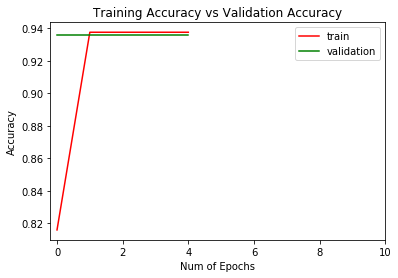

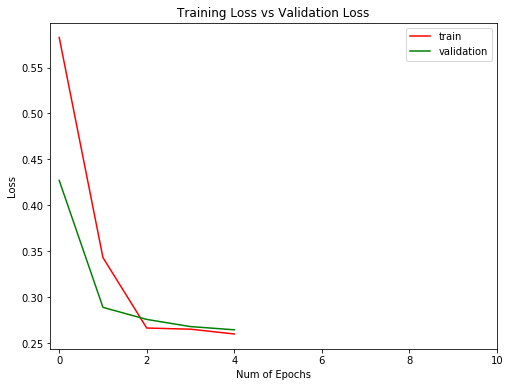

In [46]:
plt.figure(0)  
plt.plot(scnn.history['acc'],'r')  
plt.plot(scnn.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(scnn.history['loss'],'r')  
plt.plot(scnn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

In [47]:
scnn_pred = scnn_model.predict(x_test, batch_size=128, verbose=1)  
scnn_predicted = np.argmax(scnn_pred, axis=1)

2134/2134 [==============================] - 46s 21ms/step


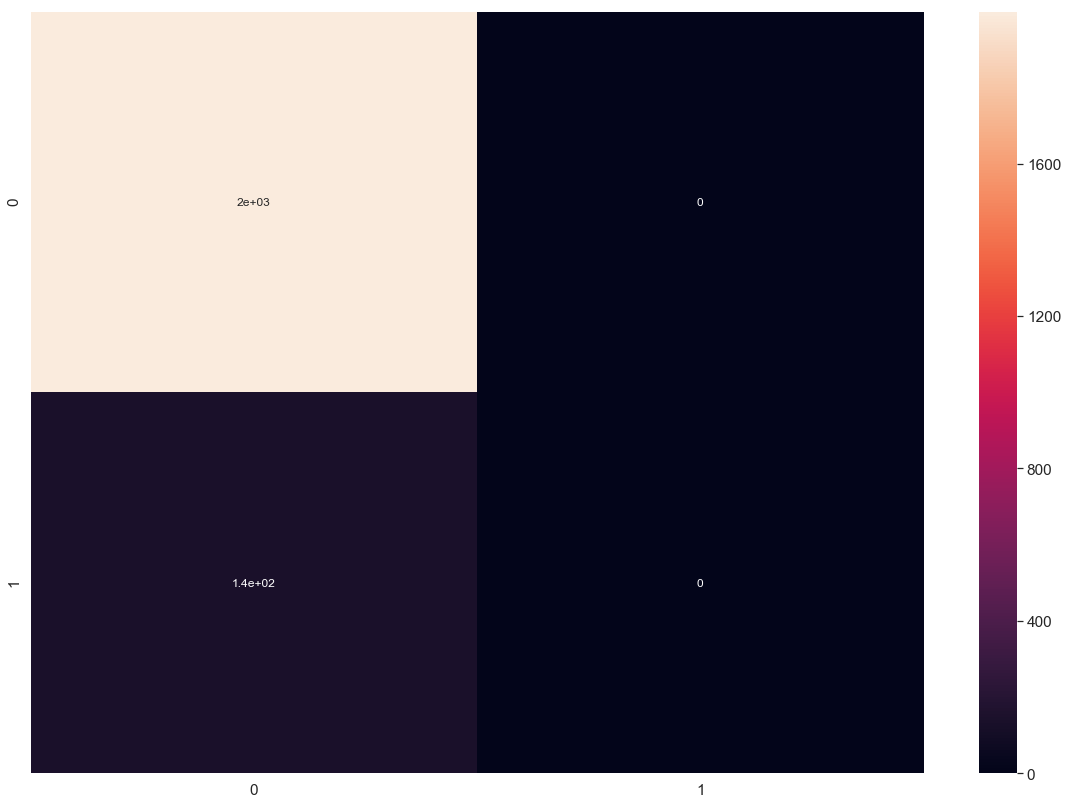

In [48]:
#Creamos la matriz de confusión
scnn_cm = confusion_matrix(np.argmax(y_test, axis=1), scnn_predicted)

# Visualiamos la matriz de confusión
scnn_df_cm = pd.DataFrame(scnn_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(scnn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

In [49]:
scnn_report = classification_report(np.argmax(y_test, axis=1), scnn_predicted)  
print(scnn_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1997
           1       0.00      0.00      0.00       137

   micro avg       0.94      0.94      0.94      2134
   macro avg       0.47      0.50      0.48      2134
weighted avg       0.88      0.94      0.90      2134



C:\Users\Michael\Anaconda3\envs\Python_3.6\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Michael\Anaconda3\envs\Python_3.6\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Michael\Anaconda3\envs\Python_3.6\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
